In [1]:
!pip install -q datasets huggingface_hub

In [2]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("zefang-liu/phishing-email-dataset")
df = dataset['train'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Phishing_Email.csv:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("hf://datasets/zefang-liu/phishing-email-dataset/Phishing_Email.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [8]:
df.shape

(18650, 3)

In [9]:
df.columns

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')

In [10]:
# Check column names
print("\n📋 Columns:", df.columns.tolist())

# Check for missing values
print("\n🔍 Missing values:\n", df.isnull().sum())

# Check class distribution
print("\n⚖️ Class distribution:")
print(df['Email Type'].value_counts(normalize=True) * 100)

# Check for duplicates
print("\n🔍 Duplicated rows:", df.duplicated().sum())

# Check unique ID consistency
print("\n🔎 Unique Email No.:", df['Unnamed: 0'].nunique(), "/", len(df))


📋 Columns: ['Unnamed: 0', 'Email Text', 'Email Type']

🔍 Missing values:
 Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

⚖️ Class distribution:
Email Type
Safe Email        60.707775
Phishing Email    39.292225
Name: proportion, dtype: float64

🔍 Duplicated rows: 0

🔎 Unique Email No.: 18650 / 18650


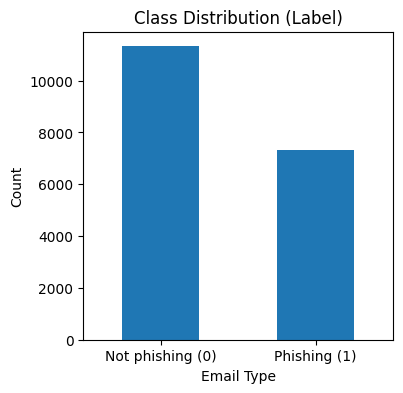

In [11]:
# Optional: visualize class distribution
plt.figure(figsize=(4,4))
df['Email Type'].value_counts().plot(kind='bar', title='Class Distribution (Label)')
plt.xticks(ticks=[0, 1], labels=['Not phishing (0)', 'Phishing (1)'], rotation=0)
plt.ylabel("Count")
plt.show()

In [12]:
# Check phishing email
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7328


In [13]:
# Remove rows where Email Text is missing
df_clean = df.dropna(subset=['Email Text'])

In [14]:
df_clean.isnull().sum()

,0
Unnamed: 0,0
Email Text,0
Email Type,0


In [15]:
# Drop first column
df_clean = df_clean.drop(columns= 'Unnamed: 0',axis=1)

In [16]:
# Check for Placeholder Text (like 'empty')
placeholder_count = (df_clean['Email Text'].str.lower() == 'empty').sum()
print(f"Rows with 'empty' as placeholder: {placeholder_count}")

Rows with 'empty' as placeholder: 533


In [17]:
# Drop empty values
df_clean = df_clean[df_clean['Email Text'].str.lower() != 'empty']

In [18]:
# Check for Truly Empty Strings
empty_string_count = (df_clean['Email Text'] == '').sum()
print(f"Empty strings (''): {empty_string_count}")

Empty strings (''): 0


In [19]:
# Binary numeric values
df_clean['Email Type'] = df_clean['Email Type'].map({'Safe Email' :1 ,'Phishing Email' : 0})

#  Define features (X) and target (y)
X = df_clean[['Email Text']]  #  text as features
y = df_clean['Email Type']   # target for stratification

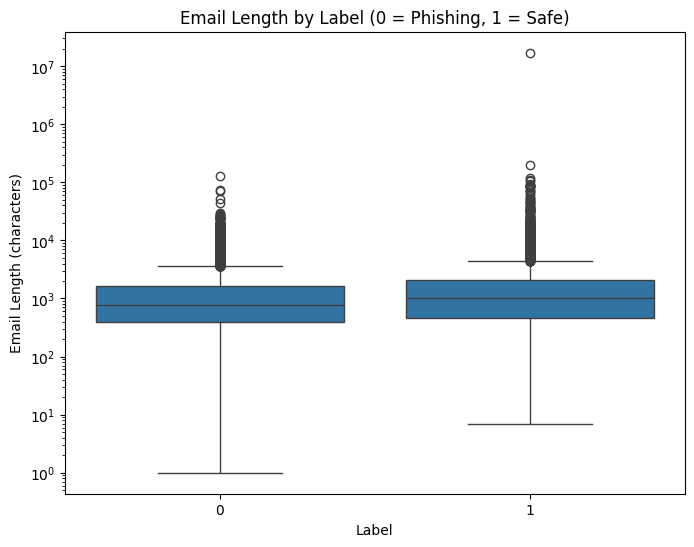

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have the character length column
df_clean['char_length'] = df_clean['Email Text'].str.len()

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Email Type', y='char_length', data=df_clean)
plt.yscale('log')
# Label and format the plot
plt.title("Email Length by Label (0 = Phishing, 1 = Safe)")
plt.xlabel("Label")
plt.ylabel("Email Length (characters)")
#plt.ylim(0, 10000)  # Optional: clip outliers for readability
plt.grid(False)
plt.show()

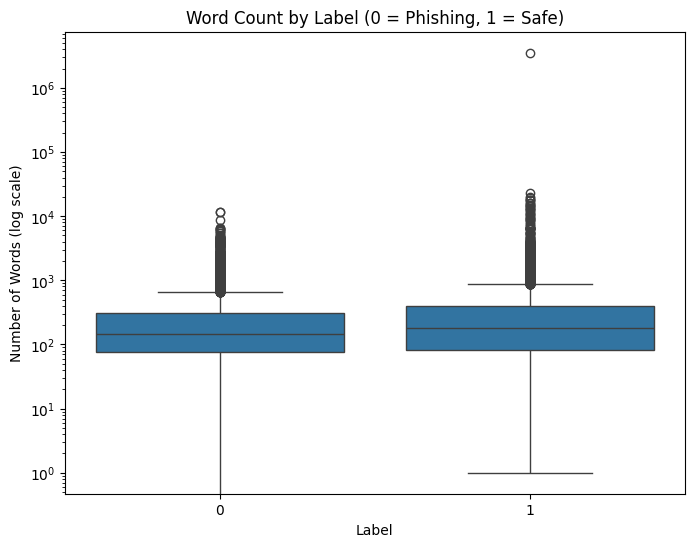

In [21]:
df_clean['word_count'] = df_clean['Email Text'].str.split().apply(len)


plt.figure(figsize=(8, 6))
sns.boxplot(x='Email Type', y='word_count', data=df_clean)
plt.yscale('log')  # optional if highly skewed
plt.title("Word Count by Label (0 = Phishing, 1 = Safe)")
plt.xlabel("Label")
plt.ylabel("Number of Words (log scale)")
plt.grid(False, which='both', axis='y')
plt.show()

In [23]:
# Perform 70-30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [24]:
# Combine X and y for convenient inspection
train_df = X_train.copy()
train_df['Label'] = y_train

test_df = X_test.copy()
test_df['Label'] = y_test

print("\nFinal splits:")
print("Train:", train_df.shape)
print("Test:", test_df.shape)


Final splits:
Train: (12670, 2)
Test: (5431, 2)


In [28]:
import re

def clean_email_text(text):
    if isinstance(text, str):
        # Normalize whitespace characters
        text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
        text = re.sub(r'\s+', ' ', text)

        # Mask email addresses
        text = re.sub(r'\b[\w.-]+?@\w+?\.\w+?\b', ' [EMAIL] ', text)

        # Mask URLs
        text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

        # Replace long numbers (IDs or phone numbers)
        text = re.sub(r'\d{5,}', ' [NUM] ', text)

        # Remove repeated punctuation like "!!!" or "??"
        text = re.sub(r'([!?.]){2,}', r'\1', text)

        # Remove unwanted characters but keep certain punctuations
        allowed_chars = r'[^\w\s\[\].,!?@-]'
        text = re.sub(allowed_chars, '', text)

        # Convert to lowercase and trim
        return text.strip().lower()

    return ""

# Apply the function
#df['clean_text'] = df['Email Text'].map(clean_email_text) for entire dataset
X_train['clean_text'] = X_train['Email Text'].map(clean_email_text)
X_test['clean_text'] = X_test['Email Text'].map(clean_email_text)

In [29]:
print(train_df.columns)

Index(['Email Text', 'Label'], dtype='object')


In [30]:
X_train = train_df['Email Text']
y_train = train_df['Label']

X_test = test_df['Email Text']
y_test = test_df['Label']

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features from the email text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

X_train = train_df['Email Text']
y_train = train_df['Label']

X_test = test_df['Email Text']
y_test = test_df['Label']

# Convert text to numerical features
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train an SVM with a linear kernel
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_vec, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_vec)

# Evaluation
print("🔍 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("✅ SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

🔍 SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2093
           1       0.99      0.99      0.99      3338

    accuracy                           0.99      5431
   macro avg       0.98      0.98      0.98      5431
weighted avg       0.99      0.99      0.99      5431

✅ SVM Accuracy: 0.9852697477444301


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_vec)

# Evaluation
print("🌲 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("✅ Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

🌲 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2093
           1       0.98      0.97      0.98      3338

    accuracy                           0.97      5431
   macro avg       0.97      0.97      0.97      5431
weighted avg       0.97      0.97      0.97      5431

✅ Random Forest Accuracy: 0.9729331614803903


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# BoW vectorizer
bow_vectorizer = CountVectorizer(stop_words='english', max_features=10000)

X_train = train_df['Email Text']
y_train = train_df['Label']

X_test = test_df['Email Text']
y_test = test_df['Label']

# Transform text to BoW vectors
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model_bow = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bow.fit(X_train_bow, y_train)

y_pred_rf_bow = rf_model_bow.predict(X_test_bow)

print("📦 Random Forest (BoW) Classification Report:")
print(classification_report(y_test, y_pred_rf_bow))
print("✅ Random Forest (BoW) Accuracy:", accuracy_score(y_test, y_pred_rf_bow))

📦 Random Forest (BoW) Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2093
           1       0.98      0.98      0.98      3338

    accuracy                           0.97      5431
   macro avg       0.97      0.97      0.97      5431
weighted avg       0.97      0.97      0.97      5431

✅ Random Forest (BoW) Accuracy: 0.9744061867059474
